In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(stringr)
library(DT)
library(tidyr)
library(corrplot)
library(leaflet)
library(lubridate)
library(data.tree)
library(purrr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

corrplot 0.84 loaded

Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date


Attaching package: ‘purrr’

The following object is masked from ‘package:data.table’:

    transpose



In [2]:
i3 <- iris
i3$Noise <- as.factor(floor(runif(nrow(iris), 0, 4)))
attr_names <- names(i3)[-5]
class_name <- names(i3)[5]
lvls <- levels(i3$Species)
inf <- 99999

In [254]:
#Entropy utility function
ent_util <- list(func=function(data){
    return(
        function(col){
            -get_best_val(get(col, data$xs), data$ys, col)$ent
        }
    )
}, sens=(log(1000)+1)/(1000*log(2)))

#Two functions for computing exponential mech.
exp_mech2 <- function(data, domain, util, eps){
    n <- length(domain)
    wghts <- exp(eps*sapply(domain, util$func(data)) / (2*util$sens))
    prob <- wghts / sum(wghts)
    u <- runif(1)
    i <- min(n, findInterval(u, cumsum(prob))+1)
    return(domain[[i]])
}
exp_mech <- function(domain, util, eps, sens=1){
    if(eps == 0){
        return(domain[util==max(util)][[1]])
    }
    util <- util-max(util)
    n <- length(domain)
    wghts <- exp(eps*util / (2*sens))
    if(sum(wghts) < 0.001){
        return(exp_mech(domain, util, 0, sens))
    }
    prob <- wghts / sum(wghts)
    u <- runif(1)
    i <- min(n, findInterval(u, cumsum(prob))+1)
    return(domain[[i]])
}

In [150]:
#Entropy function
get_ent <- function(r){
    if(!is.matrix(r)){
        r <- matrix(r, nrow=1)
    }
    r <- r / rowSums(r)
    ent <- -r*log(r) / log(2)
    ent[is.nan(ent)] = 0
    return(rowSums(ent))
}
#Computes conditional utility of a real attribute as well as the value to split on
cond_eval_num <- function(xs, ys, uti=get_ent, eps=0, min=0, max=100){
    if(length(ys) == 0){
        return(list(ent=inf, split=runif(1, min, max), type='numeric'))
    }
    xs_ord <- order(xs)
    ys_ord <- ys[xs_ord]
    ind <- matrix(sapply(levels(ys), function(x){cumsum(as.integer(ys_ord == x))}), ncol=length(levels(ys)))
    ind2 <- -sweep(ind, 2, ind[nrow(ind), ])
    changed <- xs[xs_ord] != shift(xs[xs_ord], type='lead')
    changed[is.na(changed)] = TRUE
    ind <- subset(ind, changed)
    ind2 <- subset(ind2, changed)
    d <- nrow(ind)
    ents <- c(uti(ind[d, ]),  (uti(ind) * 1:d + uti(ind2) * (d-1):0)/d)
    if(eps == 0){
        split_ind <- which(ents == min(ents))[[1]]
        return(list(ent=ents[split_ind], split=xs[xs_ord[changed][split_ind]], type='numeric'))
    }
    split_ind <- exp_mech(1:length(ents), -ents, eps, ent_util$sens)
    if(split_ind != 1)
        min = xs[xs_ord[changed][split_ind-1]]
    if(split_ind != d+1)
        max = xs[xs_ord[changed][split_ind]]
    s <- runif(1, min, max)
    return(list(ent=ents[split_ind], split=s, type='numeric'))
}
#Computes conditional utility of a factor variable
cond_eval_fac <- function(xs, ys, uti=get_ent){
    t <- table(xs, ys)
    ents <- uti(table(xs, ys)) * rowSums(t)
    ent <- sum(ents) / sum(t)
    if(is.nan(ent))
        ent <- inf
    return(list(ent=ent, split=levels(xs), type='factor'))
}
#cond_eval_num(i3$Sepal.Length, i3$Species, "Sepal_Length")
#cond_eval_fac(i3$Noise, i3$Species, "")

In [151]:
#An equality functional
equality <- function(a){
    function(d){
        d == a
    }
}
#Returns a non-private decision tree (helper)
decision_tree <- function(data, pred, attrs, node, d){
    p <- get(pred, data)
    if(length(attrs) == 0 || d <= 0 || get_ent(table(p)) == 0){
        m <- data.frame(table(p))
        idx <- which.max(m$Freq)
        guess <- m$p[idx]
        node$guess <- guess
        node$name <- paste(node$name, guess, sep=';')
        return()
    }
    best_attr <- list(ent=inf)
    for(c in attrs){
        xs <- get(c, data)
        e <- 0
        if(class(xs) == 'factor')
            e <- cond_eval_fac(xs, p)
        else if(class(xs) == 'numeric')
            e <- cond_eval_num(xs, p)
        e$name <- c
        if(e$ent < best_attr$ent){
            best_attr <- e
        }
    }
    node$name <- paste(node$name, best_attr$name, sep=';')
    ba <- best_attr$name
    nl <- attrs[attrs!= ba]
    if(best_attr$type == 'numeric'){
        s1 <- get(ba, data) < best_attr$split
        s <- best_attr$split
        decision_tree(data[s1,], pred, nl,  node$AddChild(paste("<=", s, sep='')), d-1)
        decision_tree(data[!s1,], pred, nl, node$AddChild(paste(">", s, sep='')), d-1)
        node$pars <- c(function(d){return(d <= s)}, function(d){return(d > s)})
    }else if(best_attr$type == 'factor'){
        p <- get(ba, data)
        dec_f <- lapply(best_attr$split, equality)
        for(a in best_attr$split){
            decision_tree(data[p == a,], pred, nl, node$AddChild(a), d-1)
        }
        node$pars <- dec_f
    }
    node$attr <- ba
}
#Returns a decision tree (call this one)
dtree <- function(data, pred, attrs, d=3){
    dt <- Node$new('')
    decision_tree(data, pred, attrs, dt, d)
    return(dt)
}

In [285]:
#Returns Laplacian Noise
laplacian <- function(epsilon, len=1, sensitivity=1){
    lam <- epsilon/sensitivity
    sign <- 1-2*as.integer(runif(len) < 0.5)
    return(rexp(len, lam)*sign)
}
claplace <- function(x, lambda){
    if(x < 0)
        return(0.5*exp(x*lambda))
    else
        return(1-0.5*exp(-x*lambda))
        
}
#Noises a vector of histogram values (sensitivity 1, final value cannot be negative)
hist_noiser <- function(vals, epsilon=0){
    if(epsilon==0)
        return(vals)
    fuzz <- vals + laplacian(epsilon, length(vals))
    count <- sum(fuzz < 0)
    while(count > 0){
        fuzz[fuzz < 0] <- laplacian(epsilon, count)
        count <- sum(fuzz < 0)
    }
    return(fuzz)
}

In [256]:
#Picks which conditional utility function to use, factor or numeric
#name, ent, split, type
cond_eval <- function(name, data, range_bounds, ys){
    xs <- get(name, data)
    r <- 0
    if(class(xs) == 'numeric'){
        b <- get(name, range_bounds)
        r <- cond_eval_num(xs, ys, min=b$min, max=b$max)
    }else if(class(xs) == 'factor')
        r <- cond_eval_fac(xs, ys)
    r$name <- name
    return(r)
}
#Produces a private decision tree (Helper function)
decision_tree_private <- function(data, range_bounds, pred, attrs, node, eps, d){
    p <- get(pred, data)
    sizes <- lapply(data, function(col){
        if(class(col) == 'numeric')
            return(2)
        return(length(levels(col)))
    })
    t <- sizes[attrs] %>% reduce(`max`)
    C <- get(pred, sizes)
    nrows <- hist_noiser(nrow(data), eps)
    node$nrows <- nrows
    if(length(attrs) == 0 || d <= 0 || nrows / (C*t) < sqrt(2) / eps && eps != 0){
        m <- data.frame(table(p))
        node$counts <-  hist_noiser(m$Freq, eps) #m$Freq+laplacian(eps, nrow(m))
        idx <- which.max(node$counts)
        guess <- m$p[idx]
        node$guess <- guess
        node$name <- paste(node$name, guess, sep=';')
        return()
    }
    atp <- lapply(attrs, function(name) cond_eval(name, data, range_bounds, p))
    best_attr <- exp_mech(atp, sapply(atp, function(x) -x$ent), eps, ent_util$sens)
    node$name <- paste(node$name, best_attr$name, sep=';')
    node$branch <- node$name
    ba <- best_attr$name
    nl <- attrs[attrs!= ba]
    if(best_attr$type == 'numeric'){
        s1 <- get(ba, data) < best_attr$split
        s <- best_attr$split
        decision_tree_private(data[s1,], range_bounds, pred, nl, node$AddChild(paste("<=", s, sep='')), eps, d-1)
        decision_tree_private(data[!s1,], range_bounds, pred, nl, node$AddChild(paste(">", s, sep='')), eps, d-1)
        node$pars <- c(function(d){return(d <= s)}, function(d){return(d > s)})
    }else if(best_attr$type == 'factor'){
        p <- get(ba, data)
        dec_f <- lapply(best_attr$split, equality)
        for(a in best_attr$split){
            decision_tree_private(data[p == a,], range_bounds, pred, nl, node$AddChild(a), eps, d-1)
        }
        node$pars <- dec_f
    }
    node$attr <- ba
}
#Returns a private decision tree (call this one)
dt_private <- function(data, range_bounds, pred, attrs, B, d=3){
    dt_p <- Node$new('')
    eps <- B/(2*(d+1))
    decision_tree_private(data, range_bounds, pred, attrs, dt_p, eps, d)
    return(dt_p)
}

In [181]:
test_private(adult, adult_maxes, xs_name, y_name, 0, d=5)

[1] 0.8347423

In [180]:
test_private(adult, adult_maxes, xs_name, y_name, 100000, d=5)

[1] 0.8345765

In [160]:
#Predicts the output for a dataset given the 
predict <- function(t, D, levels){
    preds <- rep(levels[[1]], nrow(D))
    if(nrow(D) == 0)
        return(preds)
    if(!is.null(t$guess)){
        return(rep(t$guess, nrow(D)))
    }
    for(i in 1:length(t$pars)){
        mask <- t$pars[[i]](get(t$attr, D))
        preds[mask] <- predict(t$children[[i]], D[mask, ], levels)
    }
    return(preds)
}

In [9]:
#Pruning helper method
top_down <- function(t, ratio){
    t$nrows <- ratio*t$nrows
    if(is.null(t$guess)){
        tot_child <- 0
        for(c in t$children){
            tot_child <- tot_child + c$nrows
        }
        for(c in t$children){
            top_down(c, t$nrows / tot_child)
        }
    }
}
#Pruning helper method
bottom_up <- function(t){
    if(!is.null(t$guess)){
        t$counts <- t$counts * t$nrows / sum(t$counts)
    }else{
        cnts <- 0
        for(c in t$children){
            cnts <- cnts + bottom_up(c)
        }
        t$counts <- cnts * t$nrows / sum(cnts)
    }
    err_rate <- 1-max(t$counts) / t$nrows
    t$pess_err_rate <- err_rate + 0.67 * sqrt(err_rate * (1-err_rate) / t$nrows)
    return(t$counts)
}
#Decides if a node should be pruned using the method of C4.5
prune <- function(t){
    cond_err <- 0
    if(is.null(t$guess)){
        for(c in t$children){
            cond_err <- cond_err + c$pess_err_rate * c$nrows / t$nrows
        }
    }
    if(cond_err > t$pess_err_rate){
        t$guess <- lvls[t$counts == max(t$counts)][[1]]
        t$children <- NULL
    }else{
        for(c in t$children)
            prune(c)
    }
}
#Does a full prune (call this one)
prune_tree <- function(t){
    top_down(t)
    bottom_up(t)
    prune(t)
}

In [10]:
#ggplot(d, aes(x=i, y=a)) + geom_line() + geom_point()

In [236]:
#Tests the normal decision tree
test <- function(data, x_names, y_name, cutoff=0.8, d=3){
    len = as.integer(nrow(data) * cutoff)
    dt <- dtree(data[1:len,], y_name, x_names, d)
    ys <- get(y_name, data)[len:nrow(data)]
    pres <- predict(dt, data[len:nrow(data),], as.factor(levels(ys)))
    return(sum(pres == ys) / (nrow(data) - len))
}
#Tests the private decision tree
test_private <- function(data, range_bounds, x_names, y_name, eps, cutoff=0.8, d=3, tree_func=dt_private){
    len = as.integer(nrow(data) * cutoff)
    dtp <- tree_func(data[1:len,], range_bounds, y_name, x_names, eps, d)
    ys <- get(y_name, data)[len:nrow(data)]
    pres <- predict(dtp, data[len:nrow(data),], as.factor(levels(ys)))
    return(sum(pres == ys) / (nrow(data) - len))
}

In [13]:
#Import adult dataset
adult <- fread('../data-unsorted/adult/adult_cleaner_no_relationship.csv')
#We need to know how to 
adult_maxes = list(age=list(min=16, max=100), education.num=list(min=1, max=16), capital.gain=list(min=0, max=99999),
                  capital.loss=list(min=0, max=99999), hours.per.week=list(min=1, max=100))

In [14]:
#My implementation can only handle numerics or factors
to_num_fac <- function(row){
    if(class(row) == 'integer')
        return(as.numeric(row))
    else if(class(row) == 'character')
        return(as.factor(row))
    return(row)
}

In [15]:
adult <- data.frame(adult %>% lapply(to_num_fac))

In [16]:
len <- as.integer(nrow(adult) * 0.5)
y_name <- names(adult)[13]
xs_name <- names(adult)[-13]
dt_p <- dt_private(adult[1:len, ], adult_maxes, y_name, xs_name, 10)

In [299]:
decision_tree_private2 <- function(data, range_bounds, pred, attrs, node, eps, d){
    p <- get(pred, data)
    if(length(attrs) == 0 || d <= 0 ){
        m <- data.frame(table(p))
        node$counts <-  hist_noiser(m$Freq, eps)
        idx <- which.max(node$counts)
        guess <- m$p[idx]
        node$guess <- guess
        node$name <- paste(node$name, guess, sep=';')
        return()
    }
    sizes <- lapply(data, function(col){
        if(class(col) == 'numeric')
            return(2)
        length(levels(col)) %>% return
    })
    t <- sizes[attrs] %>% reduce(`max`)
    C <- get(pred, sizes)
    N <- nrow(data)+0.01
    if_prob <- claplace(-N/(t*C) + sqrt(2)/eps, eps) %>% log #sensitivity epsilon/2
    uti1 <- lapply(levels(p), function(x) list(ent=sum(p == x) / N - if_prob, name=x))
    atp <- lapply(attrs, function(name) cond_eval(name, data, range_bounds, p))
    U <- c(atp, uti1)
    #print(sapply(U, function(x) -x$ent))
    best_attr <- exp_mech(U, sapply(U, function(x) -x$ent), eps, ent_util$sens)
    node$name <- paste(node$name, best_attr$name, sep=';')
    if(is.null(best_attr$split)){
        node$guess <- best_attr$name
        return()
    }
    node$branch <- node$name
    ba <- best_attr$name
    nl <- attrs[attrs!= ba]
    if(best_attr$type == 'numeric'){
        s1 <- get(ba, data) < best_attr$split
        s <- best_attr$split
        decision_tree_private2(data[s1,], range_bounds, pred, nl, node$AddChild(paste("<=", s, sep='')), eps, d-1)
        decision_tree_private2(data[!s1,], range_bounds, pred, nl, node$AddChild(paste(">", s, sep='')), eps, d-1)
        node$pars <- c(function(d){return(d <= s)}, function(d){return(d > s)})
    }else if(best_attr$type == 'factor'){
        p <- get(ba, data)
        dec_f <- lapply(best_attr$split, equality)
        for(a in best_attr$split){
            decision_tree_private2(data[p == a,], range_bounds, pred, nl, node$AddChild(a), eps, d-1)
        }
        node$pars <- dec_f
    }
    node$attr <- ba
}

dt_private2 <- function(data, range_bounds, pred, attrs, B, d=3){
    dt_p <- Node$new('')
    eps <- B/(d+1)
    decision_tree_private2(data, range_bounds, pred, attrs, dt_p, eps, d)
    return(dt_p)
}
#dt_private2(adult, adult_maxes, y_name, xs_name, 100)

In [315]:
baseline <- test(adult, xs_name, y_name, d=5)
test_eps <- c(0.5, 1:10)
m1 <- 0
m2 <- 0
for(i in 1:10){
    m1 <- m1+sapply(test_eps, function(e) test_private(adult, adult_maxes, xs_name, y_name, e, 0.8, 5, dt_private))
    m2 <- m2+sapply(test_eps, function(e) test_private(adult, adult_maxes, xs_name, y_name, e, 0.8, 5, dt_private2))
}
m1 <- m1/10
m2 <- m2/10

In [271]:
test_private(adult, adult_maxes, xs_name, y_name, 5, 0.8, 5, dt_private)

[1] 0.8126968

In [302]:
test_private(adult, adult_maxes, xs_name, y_name, 5, 0.8, 5, dt_private2)

[1] 0.827449

In [318]:
d <- data.frame(e=test_eps, A1 <- m1, A2 <- m2)

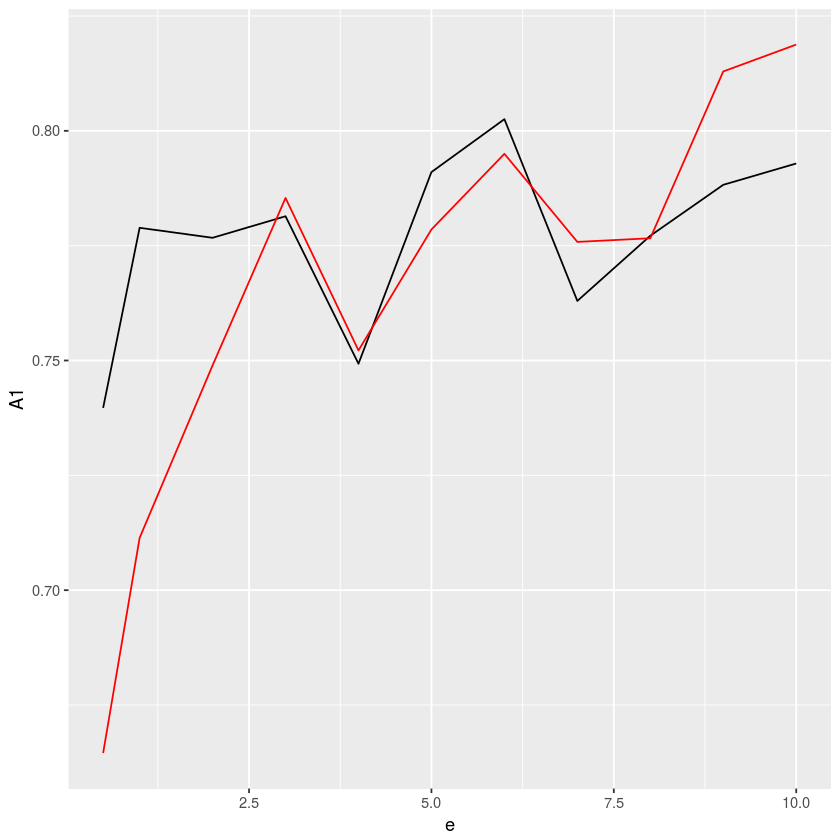

In [325]:
ggplot(d, aes(x=e, y=A1), color='blue') + geom_line() + geom_line(aes(x=e, y=A2), color='red')